### **FUENTES**:

PetFinder Kaggle:

https://www.kaggle.com/competitions/petfinder-adoption-prediction/data

First Tutorial:

https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

Second Deep Tutorial:

https://rumn.medium.com/part-1-ultimate-guide-to-fine-tuning-in-pytorch-pre-trained-model-and-its-configuration-8990194b71e

Logo Recognition API:

https://heartbeat.comet.ml/logo-recognition-ios-application-using-machine-learning-and-flask-api-aec4eff3be11

Hybrid (multimodal) neural network architecture : Combination of tabular, textual and image inputs:

https://medium.com/@dave.cote.msc/hybrid-multimodal-neural-network-architecture-combination-of-tabular-textual-and-image-inputs-7460a4f82a2e



### **INDICACIONES PREVIAS**:

+ **Git**:
    + Clonamos el repo: root de todos los repos y ponemos git clone "url_repo"
    + Hacemos el checkout de la rama main: git checkout -b new-branch

+ **Poetry**:
    + Instalamos poetry: https://python-poetry.org/docs/
    + Realizamos un Update del pyproject: poetry update
    + Activamos el entorno que creo poetry: poetry shell
    + Intentamos correr una celda, si nos pide seleccionar el environment y no lo vemos en la lista, cerrar y volver abrir VSC

+ **Torch y CUDA**:
    + Verificar que versión pide torch:
        + Versión de torch instalada: poetry show (en mi caso la 1.13.1)
        + Buscar la versión correspondiente en la documentación: https://pytorch.org/get-started/previous-versions/  (en mi caso el 11.7)
    + Instalar CUDA para Torch (buscar la versión correspondiente de CUDA): https://developer.nvidia.com/cuda-11-7-0-download-archive
    + Verificar que CUDA esté funcional: correr en una celda torch.cuda.is_available()

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os
import shutil
import time
import copy
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from pathlib import Path


import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F

from augment.autoaugment import ImageNetPolicy
from augment.cutout import Cutout


# Verificamos que CUDA está funcional
torch.cuda.is_available()

True

**Seteo el Modelo**

Teoría de Resnet: https://towardsdatascience.com/introduction-to-resnets-c0a830a288a4

In [8]:
# Importo modelo ResNet entrenado en Imagenet
resnet50 = models.resnet50(pretrained=True)
# Modificar la última capa para adaptarse a tu problema específico
num_ftrs = resnet50.fc.in_features
resnet50.fc = torch.nn.Linear(num_ftrs, 5) # Clasificación 5 clases
# Configuro para usar cuda si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)
# Instancio del criterio de pérdida CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
# Instancio Stochastic Gradient Descent (SGD): Defino el parámetro del Learning Rate (define "el paso" en que avanzan los pesos en cada iteración) y el Momentum (pone innercia a la dirección del gradiente descendiente para que no cambie de dirección en minimos locales)
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9) # Parámetros default del SGD


/home/tomas/.cache/pypoetry/virtualenvs/exp-tomi-2RV3BUvH-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tomas/.cache/pypoetry/virtualenvs/exp-tomi-2RV3BUvH-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Seteo parámetros, directorios y funciones**

In [9]:
# Paths
BASE_DIR = '/mnt/c/Users/toto_/Documents/Github/UA_MDM_LDI_II'
PATH_TO_TRAIN = os.path.join(BASE_DIR, "petfinder/train/train.csv")
PATH_TO_IMAGES_DIR = os.path.join(BASE_DIR, "petfinder/train_images")
PATH_TO_MODELS = os.path.join(BASE_DIR, "models")

# Parametros y variables
CREATE_PYTORCH_DIRECTORIES = 1
SEED = 17
TEST_SIZE = 0.2
IMAGE_SIZE = 299
BATCH_SIZE = 10
NUM_EPOCHS = 15
CPU_CORES = os.cpu_count()

# Armo el nuevo directorio de train
new_train_directory = os.path.join(BASE_DIR, 'petfinder/train_images_classes')
os.makedirs(new_train_directory, exist_ok=True) # si ya existe el nombre, lo deja como está

# Armo el nuevo directorio de validación
new_val_directory = os.path.join(BASE_DIR, 'petfinder/val_images_classes')
os.makedirs(new_val_directory, exist_ok=True)

# Definir las clases ordenadas
class_names = ['0', '1', '2', '3', '4']

# Mapear las etiquetas de las clases a números enteros consecutivos
class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

# Creo las carpetas de clases dentro de los directorios
for clase in class_names: # Una para cada clase
   os.makedirs(os.path.join(new_train_directory, str(clase)), exist_ok=True)
   os.makedirs(os.path.join(new_val_directory, str(clase)), exist_ok=True)


# Funciones para la carga y el preproceso
def resize_to_square(im):
    old_size = im.shape[:2] # old_size is in (height, width) format
    # Calcula el factor de escala necesario para redimensionar la imagen de manera que el lado más largo tenga el tamaño deseado 
    ratio = float(IMAGE_SIZE)/max(old_size)
    # Calcula las nuevas dimensiones de la imagen 
    new_size = tuple([int(x*ratio) for x in old_size])
    # Redimensiona la imagen con el nuevo tamaño
    im = cv2.resize(im, (new_size[1], new_size[0]))
    # Calcula las diferencias de tamaño y agrega pixeles (color negro) en los extremos para que quede centrada y cuadrada 
    delta_w = IMAGE_SIZE - new_size[1]
    delta_h = IMAGE_SIZE - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_image = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_image


def load_image(pet_id):
    path_to_image = os.path.join(PATH_TO_IMAGES_DIR, f'{pet_id}-1.jpg') # Irá a la primera imagen de la mascota
    image = cv2.imread(path_to_image)
    # Convierte la imagen de BGR a RGB porque estos modelos esperan ese orden de canales
    image = cv2.convertScaleAbs(image)
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    new_image = resize_to_square(image)
    return new_image

def visualize_pet(pet_id):
    path_to_image = os.path.join(PATH_TO_IMAGES_DIR, f'{pet_id}-1.jpg') # Irá a la primera imagen de la mascota
    # Cargar la imagen
    image_to_show = cv2.imread(path_to_image)
    # Convertir a formato RGB
    image_to_show = cv2.cvtColor(image_to_show, cv2.COLOR_BGR2RGB)
    # Visualizar la imagen
    plt.imshow(image_to_show)
    plt.axis('off')  # No mostrar los ejes
    plt.show()

def visualize_image(image):
    # Convierte la imagen a un formato de enteros (CV_8U)
    image = cv2.convertScaleAbs(image)
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Visualizar la imagen
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')  # No mostrar los ejes
    plt.show()


**Cargo y Proceso Data**

Nota: Pytorch necesita que estén las imágenes en los distintos directorios según su clase y su participación en el training

In [10]:
# Cargo
train_df = pd.read_csv(PATH_TO_TRAIN)

# Split para validación
train_data, val_data = train_test_split(train_df, test_size=TEST_SIZE, random_state=SEED)

if CREATE_PYTORCH_DIRECTORIES == 0: # Poner en 0 si ya tengo las carpetas train_images_classes y val_images_classes con las imágenes copiadas
    # Función para copiar las imágenes a los directorios correspondientes
    def copy_imag(data, directorio_destino):
        for index, row in data.iterrows():
            petID = row['PetID']
            adoption_speed = row['AdoptionSpeed']
            
            # Nombre del archivo de imagen
            nombre_archivo = f"{petID}-1.jpg"
            
            # Ruta completa de la imagen de origen
            ruta_origen = os.path.join(PATH_TO_IMAGES_DIR, nombre_archivo)
            
            # Ruta completa del directorio de destino
            ruta_destino = os.path.join(directorio_destino, str(adoption_speed), nombre_archivo)
            
            # Verificar si el archivo de origen existe
            if os.path.exists(ruta_origen):
                # Copiar el archivo de origen al directorio de destino
                shutil.copy2(ruta_origen, ruta_destino)
        print("Completada la copia a: ",str(directorio_destino))

    # Copiar las imágenes al directorio de train
    copy_imag(train_data, new_train_directory)

    # Copiar las imágenes al directorio de val
    copy_imag(val_data, new_val_directory)

    print("Proceso completado.")

In [11]:
# Genero los DataLoaders
def create_dataloaders(train_directory, val_directory, batch_size, num_workers):
    # Transformaciones de imagen para el conjunto de entrenamiento
    train_transforms = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        ImageNetPolicy(), ########################### AGREGO LAS POLITICAS DE AUTOAUGMENT PARA IMAGENET ###################
        transforms.ToTensor(),
        Cutout(n_holes=1, length=16),  ########################### AGREGO CUTOUT PARA REGULARIZACIÓN ###################
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Transformaciones de imagen para el conjunto de validación (sin data augment)
    val_transforms = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Crear conjuntos de datos para el conjunto de entrenamiento y validación
    conjunto_entrenamiento = datasets.ImageFolder(train_directory, transform=train_transforms)
    conjunto_validacion = datasets.ImageFolder(val_directory, transform=val_transforms)

    # Asignar las clases ordenadas al conjunto de datos
    conjunto_entrenamiento.class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}
    conjunto_validacion.class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

    # Crear dataloaders para el conjunto de entrenamiento y validación
    train_dataloader = torch.utils.data.DataLoader(conjunto_entrenamiento, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_dataloader = torch.utils.data.DataLoader(conjunto_validacion, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_dataloader, val_dataloader

# Aplico las funcion de los DataLoaders
train_dataloader, val_dataloader = create_dataloaders(new_train_directory , new_val_directory , BATCH_SIZE, CPU_CORES)

**Entreno**

In [12]:
def train_val(model, criterion, optimizer, dataloaders, datasets, device, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])
            
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                phase.title(), epoch_loss, epoch_acc * 100))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(best_acc * 100))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model

best_model = train_val(resnet50, criterion, optimizer,dataloaders={'train': train_dataloader, 'val': val_dataloader}, datasets={'train': train_data, 'val': val_data}, device=device, num_epochs=NUM_EPOCHS)
# Guardo el modelo
run_id = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f'modelo_entrenado_{run_id}.pth'
model_path = os.path.join(PATH_TO_MODELS, file_name)
torch.save(best_model, model_path) # Podemos guardar solo los pesos si queremos: best_model.state_dict()
print(f'Modelo guardado en {model_path}')

Epoch 0/14
----------


Train Loss: 1.4697 Acc: 29.84%
Val Loss: 1.4165 Acc: 31.81%

Epoch 1/14
----------
Train Loss: 1.3912 Acc: 33.39%
Val Loss: 1.3941 Acc: 34.11%

Epoch 2/14
----------
Train Loss: 1.3714 Acc: 34.56%
Val Loss: 1.4052 Acc: 32.51%

Epoch 3/14
----------
Train Loss: 1.3541 Acc: 36.26%
Val Loss: 1.3914 Acc: 34.64%

Epoch 4/14
----------
Train Loss: 1.3271 Acc: 38.31%
Val Loss: 1.4091 Acc: 35.95%

Epoch 5/14
----------
Train Loss: 1.3117 Acc: 38.71%
Val Loss: 1.4643 Acc: 33.04%

Epoch 6/14
----------
Train Loss: 1.2900 Acc: 40.45%
Val Loss: 1.4713 Acc: 35.01%

Epoch 7/14
----------
Train Loss: 1.2758 Acc: 41.87%
Val Loss: 1.4864 Acc: 32.88%

Epoch 8/14
----------
Train Loss: 1.2447 Acc: 43.66%
Val Loss: 1.4921 Acc: 33.28%

Epoch 9/14
----------
Train Loss: 1.2178 Acc: 44.96%
Val Loss: 1.5579 Acc: 31.94%

Epoch 10/14
----------
Train Loss: 1.1879 Acc: 47.88%
Val Loss: 1.6283 Acc: 33.38%

Epoch 11/14
----------
Train Loss: 1.1654 Acc: 48.17%
Val Loss: 1.6428 Acc: 31.68%

Epoch 12/14
----------
T

### **BORRADOR**

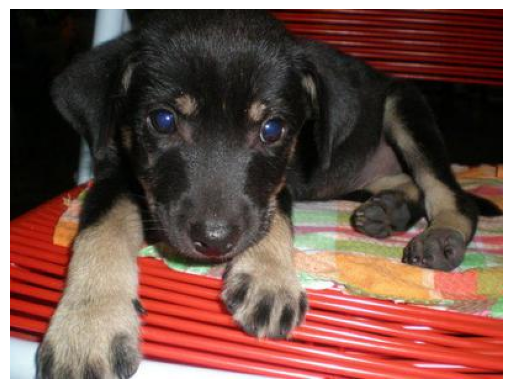

In [17]:
# Seleccionar el PetID a mostrar
visualize_pet("5842f1ff5")

**Prueba de carga en cero con Validador**

Predigo todo el val_set desde una carga desde cero para chequear que el proceso de inferencia funciona bien

In [4]:
BASE_DIR = '/mnt/c/Users/toto_/Documents/Github/UA_MDM_LDI_II'
PATH_TO_MODELS = os.path.join(BASE_DIR, "models")
RUN_NAME = "modelo_entrenado_20240319_193658"
IMAGE_SIZE = 299
path_to_model =  os.path.join(PATH_TO_MODELS, f"{RUN_NAME}.pth")

PATH_TO_TRAIN = os.path.join(BASE_DIR, "petfinder/train/train.csv")
SEED = 17
TEST_SIZE = 0.2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(path_to_model, map_location=device)

test_transforms = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])
                                    ])


class_names = ['0', '1', '2', '3', '4'] 

def get_inference(image_path, model, device, classes):

        image = Image.open(Path(image_path))
        image_tensor = test_transforms(image).float()
        image_tensor = image_tensor.unsqueeze_(0)
        input = Variable(image_tensor)
        input = input.to(device)
        output = model(input)
        index = output.data.cpu().numpy().argmax()
        prob = F.softmax(output, dim=1)
        return classes[index], prob

In [7]:
# Prueba con val_set
train_df = pd.read_csv(PATH_TO_TRAIN)
# Split para validación
train_data, val_data = train_test_split(train_df, test_size=TEST_SIZE, random_state=SEED)

petid_list = []
inf_class_list = []
real_class_list = []

for index, row in val_data.iterrows():
    petid = row['PetID']
    real_class = row['AdoptionSpeed']
    img_path = os.path.join(BASE_DIR, f"petfinder/train_images/{petid}-1.jpg")
    if os.path.exists(img_path):
        inf_class, prob = get_inference(img_path, model, device,class_names)
        
        petid_list.append(petid)
        real_class_list.append(real_class)
        inf_class_list.append(inf_class)

df_val = pd.DataFrame({'PetID':petid_list,'Real_Class':real_class_list,'Inf_Class':inf_class_list})
df_val['Real_Class'] = df_val['Real_Class'].astype(str)
df_val['acc']= np.where(df_val['Real_Class']==df_val['Inf_Class'],1,0)
print(df_val['acc'].mean())
df_val

0.32539142273655547


,PetID,Real_Class,Inf_Class,acc
0,4f7bfcb68,4,4,1
1,780dff088,4,2,0
2,583d4b36c,2,2,1
3,ff7ff0f3c,1,2,0
4,1a2c23d4c,1,2,0
...,...,...,...,...
2933,f83695eb0,4,2,0
2934,aa03b987e,2,2,1
2935,cf98480e0,2,2,1
2936,b8db25430,1,1,1


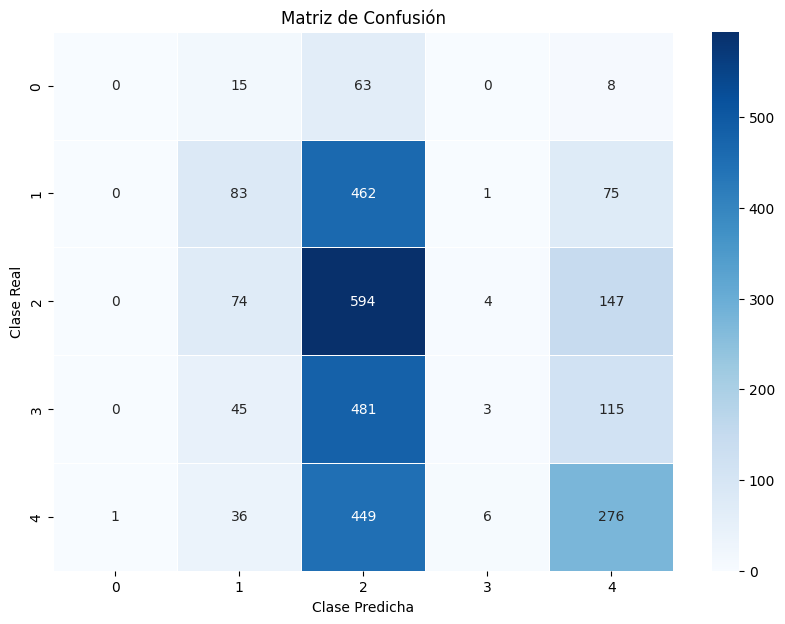

In [8]:

def plot_confusion_matrix(true_class, predicted_class, class_names):
    # Calcular la matriz de confusión
    cm = confusion_matrix(true_class, predicted_class, labels=class_names)
    
    # Crear un dataframe para la matriz de confusión
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # Crear el heatmap de la matriz de confusión
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", linewidths=0.5)
    plt.title('Matriz de Confusión')
    plt.xlabel('Clase Predicha')
    plt.ylabel('Clase Real')
    plt.show()

# Ejemplo de uso:

plot_confusion_matrix(df_val['Real_Class'], df_val['Inf_Class'], class_names)